#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
# diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[0.005, 0.   , 0.   ],
       [0.   , 0.005, 0.   ],
       [0.   , 0.   , 0.01 ]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [16]:
V_rho

array([[6.0751987e+10, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 6.0751987e+10, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 6.0751987e+10]])

In [17]:
fin_123=[]
for i in range(node_N):
    V_rho+=Irho_
    fin_123.append(V_rho.copy())

In [18]:
Irho=np.array(fin_123[::-1])
# Irho=np.array(fin_123)

In [19]:
# Irho+=vessel_inertia

In [20]:
Irho[-1][0][0]

60751987031.25499

In [21]:
Irho[-49][0][0]

60751987031.49486

In [22]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [23]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [24]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [25]:
E = 210e9

In [26]:
E*Ar/1e10

1.6991625880187402

In [27]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [28]:
DT=np.diag(diag_DT) # (35) in [2]

In [29]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [30]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [31]:
CT=np.diag(diag_CT)

In [32]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [33]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [34]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [35]:
rng = np.random.default_rng()

In [36]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [37]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [38]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.23270988, -0.95561532,  0.1806806 ],
       [ 0.34381464,  0.25461998,  0.90385848],
       [-0.9097459 , -0.14821616,  0.38780712]])

In [39]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.005425


In [40]:
Ret.shape

(50, 3, 3)

In [41]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [42]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [43]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000326


In [44]:
C1(dx,dy,dz,Ret)

array([[-4.11281756e+00, -1.79950446e+00, -6.06077594e-02,
        -3.12064606e-01, -6.37158225e-01, -4.65229767e+00,
        -7.71066823e-01,  7.28083328e-02, -7.94380616e-01,
        -7.12232093e+00,  2.39729178e-02, -2.83511777e-01,
        -6.10098970e-01, -1.27636526e-01,  2.94651732e-01,
        -1.26241774e+00, -2.39755906e+00,  1.77141523e-01,
         3.11009795e-01,  2.25743189e-04,  2.31756394e+00,
         7.10850012e+00,  1.95418697e+00, -1.66495049e+00,
         2.79649343e+00, -6.19462028e-01,  2.22195147e-01,
         1.61610459e-01,  5.79896587e+00,  2.68703285e-01,
        -8.24106703e-01, -1.60012675e-01,  2.21087299e-01,
         8.78506071e-02,  1.60397320e-01,  2.00596218e+00,
        -1.52744785e-02,  1.55870742e-01, -2.23655784e+00,
        -3.51264078e-01, -4.40928199e-01, -1.07054429e-01,
         9.35715034e+00,  4.08975413e-04, -4.71094939e-01,
        -3.15190817e+00, -5.79649254e-02, -1.68319626e+00,
         9.95697220e-01,  4.06726117e-02],
       [-4.60

In [45]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [46]:
fD(dx,dy,dz,DT,Ret).T

array([[-2.36035995e+04, -2.64004182e+03,  3.19181986e+03],
       [-1.03274172e+04, -9.96781507e+03, -2.50534554e+04],
       [-3.47829988e+02,  4.13104573e+04, -1.55385666e+04],
       [-1.79094937e+03,  2.13362199e+03, -7.24842804e+03],
       [-3.65667267e+03, -1.37772907e+04,  4.30423352e+03],
       [-2.66996942e+04, -1.29994467e+04, -2.47851268e+04],
       [-4.42517866e+03,  6.63545048e+03,  3.12457674e+03],
       [ 4.17849493e+02,  3.45422959e+03, -5.24869125e+03],
       [-4.55897732e+03, -6.45574880e+03,  1.77088273e+04],
       [-4.08752416e+04,  7.06525595e+03,  2.13885464e+03],
       [ 1.37581389e+02,  2.35256241e+02,  4.35839115e+02],
       [-1.62708371e+03, -6.33647058e+03,  4.76522538e+03],
       [-3.50137869e+03, -2.80419847e+04,  2.84873178e+04],
       [-7.32510354e+02,  3.63697647e+03,  2.60578283e+03],
       [ 1.69101629e+03, -1.04615669e+03, -1.60183937e+03],
       [-7.24505824e+03,  2.12719054e+04,  2.98773175e+03],
       [-1.37596728e+04,  3.06396521e+03

In [47]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.001351


In [48]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [49]:
I=np.identity(3)

In [50]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000554


In [51]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [52]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [53]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [54]:
DR=np.diag(diag_DR) 

In [55]:
Ar

0.08091250419136858

In [56]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [57]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [58]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [59]:
def Re_b(Ret):
    return Ret

In [60]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000216


In [61]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [62]:
phi(x,y,z,Ret,None,None)

array([[-1.85898463e+00,  6.88998926e-01, -2.83969841e-01],
       [ 1.28062705e+00, -2.44922342e-01, -4.20947389e-01],
       [-1.05125439e+00, -1.30950198e+00,  9.15208709e-01],
       [-3.39609423e-01,  3.49584973e-01,  4.08206503e-02],
       [ 1.78419466e-01,  4.52095434e-01, -4.34738499e-01],
       [-2.10474327e-01, -1.32575536e+00, -1.11352486e+00],
       [-3.22462226e-01,  1.93920389e+00,  7.55705404e-01],
       [ 3.56281811e-01, -7.20226274e-01, -1.04263024e+00],
       [ 4.24092412e-01, -2.07990983e-01,  7.28715178e-01],
       [ 4.78490345e-01, -7.39994543e-01, -1.86241197e+00],
       [ 2.73826350e-01, -1.18297598e+00, -5.65068564e-02],
       [ 3.86111538e-01, -6.16468692e-01, -1.48028219e+00],
       [ 1.03188162e-01,  5.30854732e-01,  1.71341781e+00],
       [ 8.20392295e-01,  4.67644105e-01, -1.12156443e+00],
       [-7.60203699e-01, -5.24084088e-01,  5.02073750e-01],
       [-3.44196988e-01, -1.64551819e+00,  9.23752142e-01],
       [ 1.70259166e+00,  2.96933097e-01

In [63]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000262


In [64]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [65]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [66]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002069


In [67]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [68]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.001230


In [69]:
ωe(φ,θ,ψ,None,None,None)

array([[ 1.66535973e+00,  3.37442452e-01, -4.61311495e-01],
       [-8.54472415e-01,  1.27962144e+00,  8.38632983e-01],
       [-9.81143657e-01, -5.32014276e-01,  5.14835221e-01],
       [ 1.29622110e+00,  7.86148652e-01, -1.13991523e+00],
       [ 1.15055974e-01,  2.35067085e+00,  1.65307170e+00],
       [-1.17808368e+00, -2.72873062e-01, -9.75171895e-02],
       [ 5.01575507e-01,  8.32229045e-01, -6.25047915e-01],
       [-1.74426285e-01,  1.29965633e+00,  9.90492468e-01],
       [ 1.17288442e+00,  9.65425597e-02, -2.67970551e-02],
       [ 8.41081704e-01, -5.61495586e-01,  3.63489120e-01],
       [ 9.37480362e-01, -2.13766790e-01, -4.59530626e-01],
       [-1.16413343e+00,  8.11193912e-01,  4.22051620e-02],
       [-1.41534289e+00, -9.92635437e-01,  2.68061115e-02],
       [-5.06099160e-01,  8.16082221e-01,  1.55600422e+00],
       [ 7.99134536e-01, -1.99492835e-01, -9.35326051e-01],
       [-9.84678185e-01, -6.00389033e-02,  3.08719091e-02],
       [ 7.83552547e-01,  1.93189259e+00

In [70]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float64)).T

In [71]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [72]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-9.72959037e-06, -1.76023287e-06,  2.22468844e-05,
        -3.08761235e-06, -8.86825065e-06,  2.12228378e-06,
        -1.18348665e-05, -3.22400738e-06,  9.36696794e-06,
        -1.12240621e-05,  1.12645786e-05, -8.63804855e-06,
         1.18255125e-05, -1.58919264e-05,  1.02614758e-05,
         2.56924463e-05, -4.82031363e-06, -2.19891523e-05,
         6.79882013e-06, -7.89441451e-06,  1.14296168e-06,
        -8.58170591e-06, -6.32072933e-07,  4.91644208e-06,
        -1.06483650e-05,  1.24536361e-05, -6.15944688e-06,
         1.86316713e-05, -1.14222219e-05,  1.94392578e-05,
        -3.52832956e-05, -1.27109336e-05, -1.26747925e-06,
         5.69732113e-06, -1.54603591e-05, -1.05053375e-05,
         3.54109291e-06, -4.29529253e-06,  4.49984746e-06,
        -1.34327628e-05, -1.21240256e-05, -2.20119936e-05,
         1.65877265e-06, -3.01102026e-05,  3.11588373e-06,
        -2.37396029e-05,  2.98320449e-05, -1.91222596e-06,
         6.17716297e-07,  5.18592898e-06],
       [-1.57

In [73]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001943


In [74]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [75]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [76]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [77]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [78]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-1.14844137e-06, -1.72521797e-06,  5.47014998e-07,
         2.76723202e-07,  2.70363740e-07,  5.47892000e-07,
        -3.13559724e-07,  1.36405521e-06,  1.10069426e-06,
        -2.54348735e-06,  2.10524107e-07, -3.09124047e-08,
         5.41726301e-07,  7.61794817e-07, -8.38150215e-08,
         6.84906019e-07,  2.39343459e-08, -3.04525813e-06,
         5.83741047e-07,  2.84563713e-07,  7.95503458e-07,
         6.36939531e-07, -7.34504655e-08,  1.28166126e-06,
         1.83264503e-06,  3.61152631e-06, -8.77904963e-07,
         1.88977430e-06, -5.62799678e-07,  7.38106698e-07,
        -1.97116388e-06, -2.11451597e-06, -5.53101412e-07,
         1.93828935e-07, -1.83062918e-06, -6.63655774e-07,
        -1.37154060e-07, -1.89796211e-07,  7.20877666e-07,
        -3.13059485e-06, -7.33465482e-07,  3.38237472e-06,
         2.43155376e-08,  9.40674014e-07, -3.02021685e-07,
        -2.68222246e-06,  3.78359435e-06, -2.66584254e-07,
        -8.40275467e-07,  6.11039434e-08],
       [-1.79

In [79]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [80]:
ne_(dx,dy,dz,DT,Ret)

array([[ 2.36035995e+04,  1.03274172e+04,  3.47829988e+02,
         1.79094937e+03,  3.65667267e+03,  2.66996942e+04,
         4.42517866e+03, -4.17849493e+02,  4.55897732e+03,
         4.08752416e+04, -1.37581389e+02,  1.62708371e+03,
         3.50137869e+03,  7.32510354e+02, -1.69101629e+03,
         7.24505824e+03,  1.37596728e+04, -1.01662121e+03,
        -1.78489577e+03, -1.29554782e+00, -1.33005781e+04,
        -4.07959234e+04, -1.12151454e+04,  9.55520736e+03,
        -1.60491707e+04,  3.55511360e+03, -1.27518549e+03,
        -9.27487910e+02, -3.32804620e+04, -1.54209727e+03,
         4.72957634e+03,  9.18318174e+02, -1.26882751e+03,
        -5.04177615e+02, -9.20525662e+02, -1.15122851e+04,
         8.76607504e+01, -8.94547480e+02,  1.28356813e+04,
         2.01591646e+03,  2.53050190e+03,  6.14389000e+02,
        -5.37010034e+04, -2.34712377e+00,  2.70362984e+03,
         1.80889080e+04,  3.32662674e+02,  9.65992048e+03,
        -5.71434014e+03, -2.33421499e+02],
       [ 2.64

In [81]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.002999


In [82]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[ 1.31832273e+02, -1.44086959e+04,  1.42768634e+04],
       [ 2.70487203e+03, -2.54018599e+03, -1.64691452e+02],
       [ 1.48319965e+03, -6.90635885e+02, -7.92566736e+02],
       [ 4.44814830e+03, -5.81662462e+03,  1.36846743e+03],
       [ 1.86946324e+03,  9.84286583e+03, -1.17123328e+04],
       [-9.50845114e+02, -1.41565699e+04,  1.51074169e+04],
       [ 2.48573343e+03, -8.96332232e+03,  6.47758392e+03],
       [-8.38598874e+02, -3.22240255e+02,  1.16084081e+03],
       [ 1.24930407e+02, -1.69512328e+04,  1.68263022e+04],
       [-3.53770401e+03, -6.35345387e+03,  9.89116495e+03],
       [-2.82217300e+03, -4.05166453e+03,  6.87384317e+03],
       [-1.41459573e+03, -1.88434810e+03,  3.29894666e+03],
       [ 2.07800200e+02, -3.15593459e+02,  1.07792843e+02],
       [ 7.17160198e+00, -5.46753514e+03,  5.46036353e+03],
       [-9.36486146e+02, -1.62428490e+03,  2.56077292e+03],
       [-1.93895673e+03, -1.32850103e+04,  1.52239709e+04],
       [ 1.53900831e+03,  4.49304403e+02

In [83]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-1.42809295e+10, -4.05186104e+06,  1.27780544e+08],
       [-2.14236616e+08, -3.78927475e+08,  2.32594726e+09],
       [-1.83910280e+09, -2.63166507e+09, -1.14846393e+09],
       [ 5.40133839e+07,  1.42247934e+09,  5.87063208e+09],
       [ 1.04746944e+10, -1.23764763e+09,  6.31817481e+08],
       [-1.48334782e+10,  2.73953260e+08, -6.76892805e+08],
       [-4.78988983e+09,  1.68769720e+09,  4.17343311e+09],
       [-3.21441443e+08,  8.39398845e+08,  7.99132055e+05],
       [-1.67045316e+10,  1.21787120e+08,  2.46717651e+08],
       [-7.30999965e+09,  2.58117003e+09, -9.56537517e+08],
       [-4.18039238e+09,  2.69345228e+09, -1.28723539e+08],
       [-1.55332166e+09,  1.74562481e+09,  3.31027657e+08],
       [-3.64997363e+08, -2.57203898e+08, -4.94034900e+07],
       [-5.46197723e+09, -1.60823604e+06,  5.56337311e+06],
       [-1.04036503e+09,  1.52040741e+09,  5.83920330e+08],
       [-1.37013508e+10,  1.52263235e+09, -4.16326322e+08],
       [ 1.04383464e+09, -9.44481249e+08

In [84]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000337


In [85]:
Re_b(Ret).shape

(50, 3, 3)

In [86]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [87]:
Irho_e(Ret)

array([[[ 5.51402944e+10,  1.32948926e+10, -2.17622998e+10],
        [ 2.03310338e+10, -5.42136029e+10,  1.83939734e+10],
        [-1.53948343e+10, -2.39778027e+10, -5.36550835e+10]],

       [[-2.66563974e+10, -2.99191179e+10, -4.56627506e+10],
        [-3.97761734e+10, -2.41604359e+10,  3.90503943e+10],
        [-3.73911278e+10,  4.70310924e+10, -8.98798327e+09]],

       [[-2.01874855e+10,  4.32222679e+09, -5.71365707e+10],
        [ 4.99182344e+10, -2.84158555e+10, -1.97866864e+10],
        [-2.81325298e+10, -5.35225321e+10,  5.89094710e+09]],

       [[-2.41223519e+10, -3.08828880e+10, -4.64237364e+10],
        [ 4.68586550e+10, -3.86422846e+10,  1.35802042e+09],
        [-3.02189099e+10, -3.52679033e+10,  3.91637129e+10]],

       [[ 2.94196062e+10,  4.68436802e+10, -2.51189237e+10],
        [-4.45257101e+10,  3.73988659e+10,  1.75951670e+10],
        [ 2.90301885e+10,  9.88930666e+09,  5.24428613e+10]],

       [[ 5.34491713e+10,  2.32042651e+10,  1.71916287e+10],
        [ 5.39

In [88]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000189


In [89]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [90]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [91]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [92]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret.astype(np.float32),omega.astype(np.float32))

    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [93]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.003551


In [94]:
d_me_

array([[-3.56138641e-15, -4.53027915e-12,  4.21057580e-12],
       [-2.16626040e-16, -1.20229928e-11,  2.78912865e-11],
       [-9.08211719e-16, -3.32246065e-11,  7.71925543e-11],
       [-8.64536388e-17, -2.18482293e-11,  9.30275249e-11],
       [-2.89651838e-15, -2.67182493e-11,  4.80749755e-11],
       [-3.65267031e-15, -2.47709635e-11,  2.74582330e-11],
       [-1.71922046e-15, -8.68819454e-11,  6.28162372e-11],
       [-2.83911276e-16, -4.98966614e-11,  9.21321560e-15],
       [-3.95371069e-15, -2.75050139e-11,  2.79287914e-11],
       [-2.27890499e-15, -5.58360936e-11,  2.48735736e-11],
       [-1.57009874e-15, -3.77050137e-11,  9.24856763e-11],
       [-8.11500495e-16, -2.22190056e-11,  1.44325203e-11],
       [-3.09012558e-16, -2.92984570e-12,  7.17621840e-12],
       [-1.87649609e-15, -6.54070344e-13,  8.33518312e-14],
       [-6.21211752e-16, -1.80705745e-11,  1.33610833e-10],
       [-3.46437424e-15, -4.64592753e-11,  5.80248342e-11],
       [-6.22591569e-16, -1.30999566e-11

In [95]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [96]:
ne_(dx,dy,dz,DT,Ret)

array([[ 2.36035995e+04,  1.03274172e+04,  3.47829988e+02,
         1.79094937e+03,  3.65667267e+03,  2.66996942e+04,
         4.42517866e+03, -4.17849493e+02,  4.55897732e+03,
         4.08752416e+04, -1.37581389e+02,  1.62708371e+03,
         3.50137869e+03,  7.32510354e+02, -1.69101629e+03,
         7.24505824e+03,  1.37596728e+04, -1.01662121e+03,
        -1.78489577e+03, -1.29554782e+00, -1.33005781e+04,
        -4.07959234e+04, -1.12151454e+04,  9.55520736e+03,
        -1.60491707e+04,  3.55511360e+03, -1.27518549e+03,
        -9.27487910e+02, -3.32804620e+04, -1.54209727e+03,
         4.72957634e+03,  9.18318174e+02, -1.26882751e+03,
        -5.04177615e+02, -9.20525662e+02, -1.15122851e+04,
         8.76607504e+01, -8.94547480e+02,  1.28356813e+04,
         2.01591646e+03,  2.53050190e+03,  6.14389000e+02,
        -5.37010034e+04, -2.34712377e+00,  2.70362984e+03,
         1.80889080e+04,  3.32662674e+02,  9.65992048e+03,
        -5.71434014e+03, -2.33421499e+02],
       [ 2.64

### Static solution

In [97]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [98]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [99]:
Fx_0=82945396

In [100]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [101]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [102]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [103]:
delta_x=horizontal_length/(node_N-1)

In [104]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [105]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [106]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

In [107]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [108]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

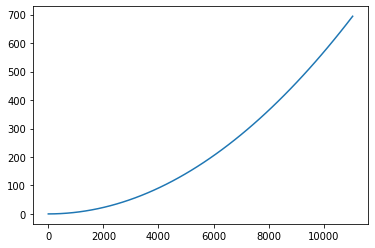

In [109]:
plt.plot(x0, z0)
plt.show()

In [110]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [111]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [112]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_totl,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################    

    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [113]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [114]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [115]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [116]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [117]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [118]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [119]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [120]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

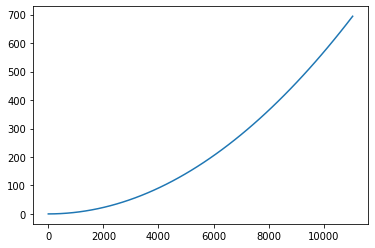

In [121]:
plt.plot(x0_, z0_)
plt.show()

In [194]:
init=1e-3
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.55*i*init for i in range(node_N)])
        q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0.001*i*init for i in range(node_N)])
        q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [195]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [196]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [197]:
vehicle=semisub('DPcontrol',0,-5,40.0,0,0) 

In [198]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [199]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

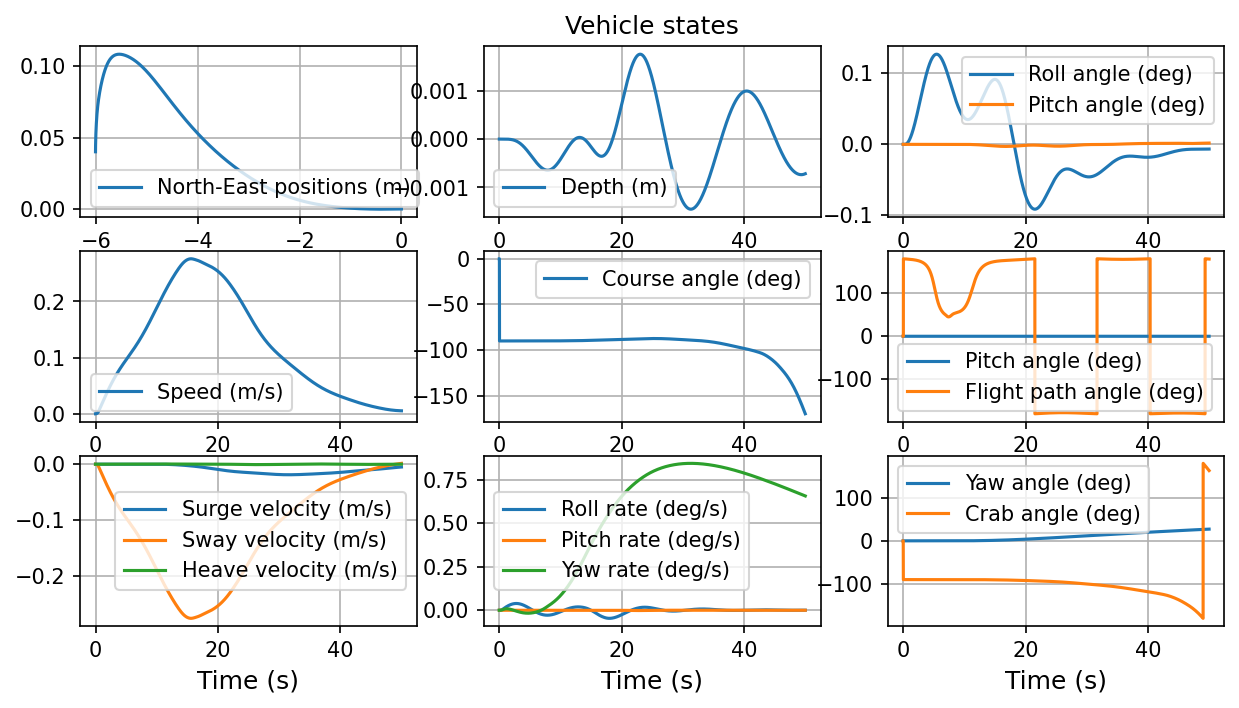

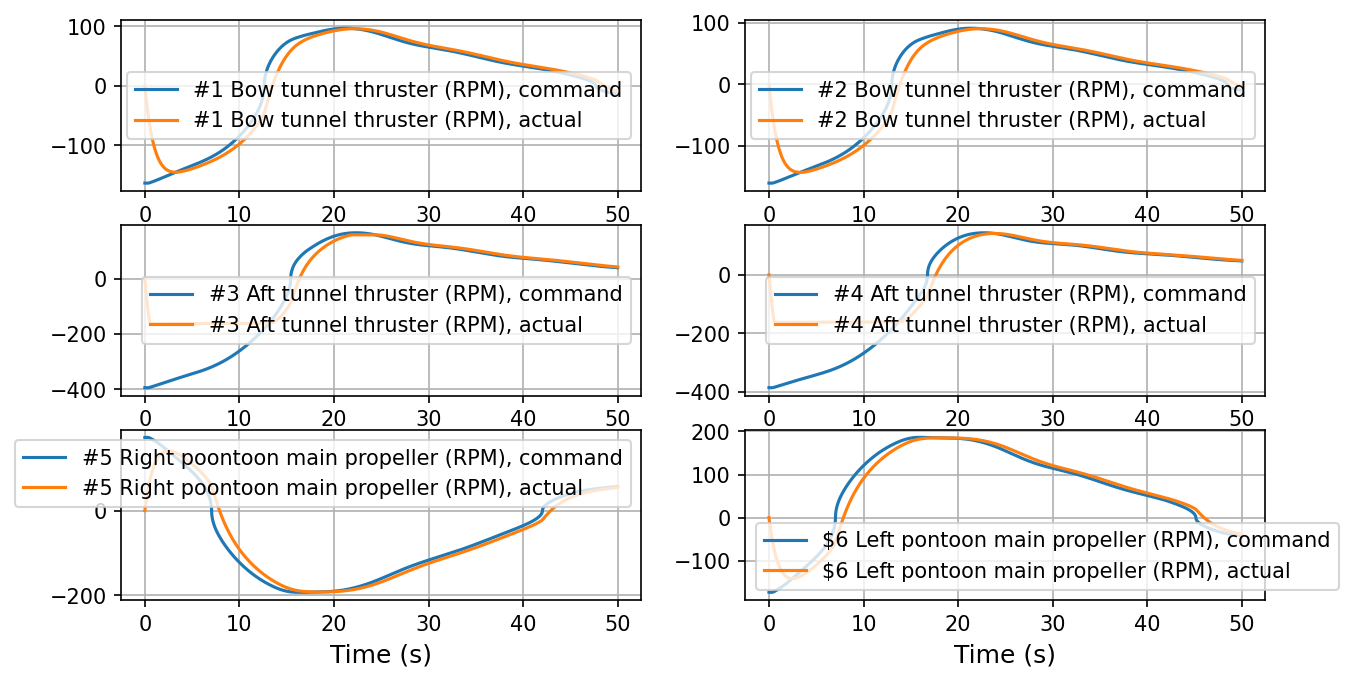

In [200]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [201]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

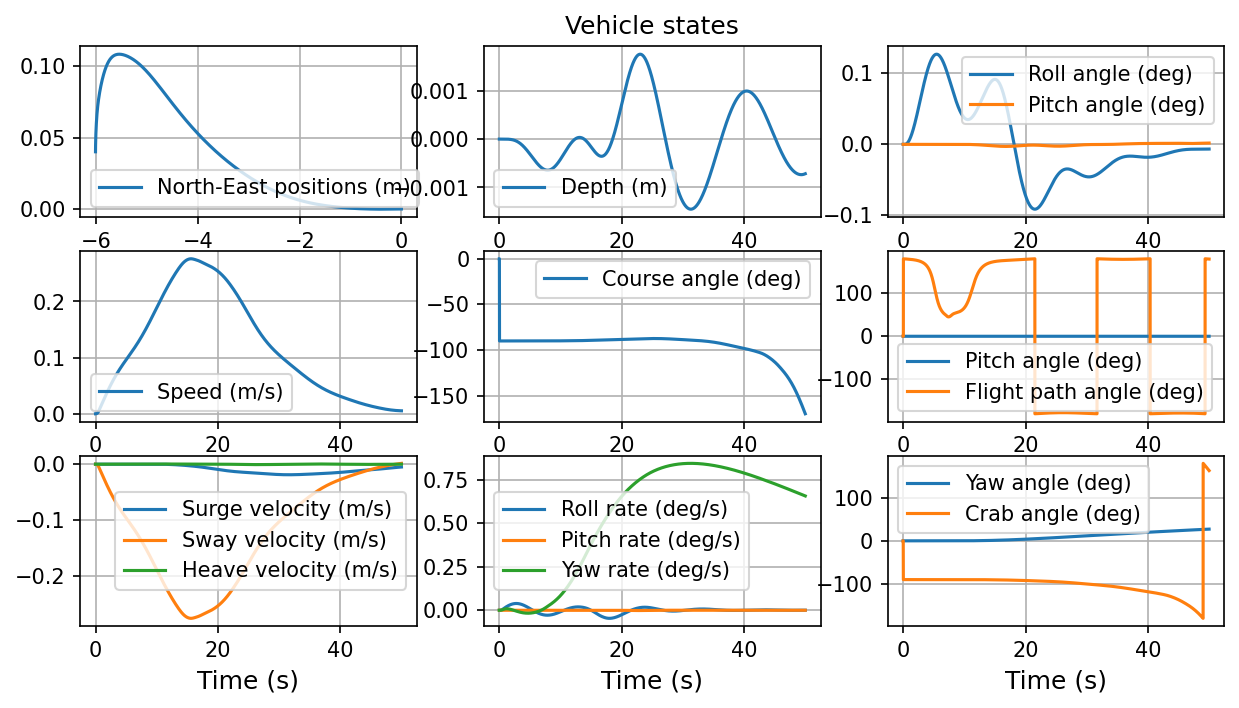

In [202]:
plotVehicleStates(simTime, simData, 3)

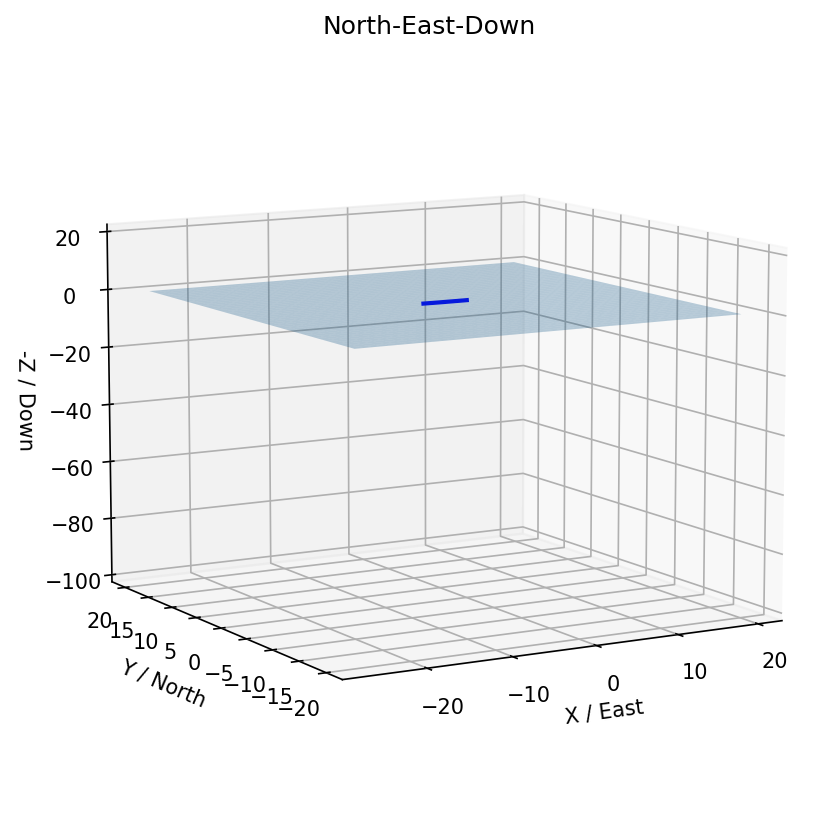

In [203]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [204]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [205]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [206]:
# Ws[0]*Ret[2]

In [207]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

### Dynamics

In [208]:
def grayscott1d(t, Q): # here
    print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=1
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

#     print(Ret)
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)

    Z= (Z1 + Z2 +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    

    RRRR=Re_b(Ret)
#     print(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
#                                              M_totl
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(C0,C1,C2,C3,C4)
#     print(B)   

    A2 = Irho_e(Ret).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [209]:
# import scipy

In [210]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [211]:
# us=ode15s.integrate(10)

In [212]:
tspan = (0., 0.01)

In [213]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0.0
2.9456883575150776e-13
5.891376715030155e-12
8.837065072545232e-12
2.356550686012062e-11
2.6183896511245133e-11
2.9456883575150776e-11
2.9456883575150776e-11
8.837065072545234e-11
1.178275343006031e-10
2.6511195217635704e-10
2.9129584868760216e-10
3.2402571932665857e-10
3.2402571932665857e-10
7.960047900386206e-10
1.0319943253946016e-09
2.211942002174507e-09
2.4217104780464897e-09
2.6839210728864686e-09
2.6839210728864686e-09
5.467430721930854e-09
6.859185546453046e-09
1.3817959669064008e-08
1.505507506863929e-08
1.6601469318108393e-08
1.6601469318108393e-08
2.99965797274376e-08
3.66941349321022e-08
7.018191095542522e-08
7.613529335957153e-08
8.357702136475443e-08
8.357702136475443e-08
1.3687295759099825e-07
1.635209257041201e-07
2.9676076626972964e-07
3.204478490369491e-07
3.500567024959734e-07
3.500567024959734e-07
5.418838311168381e-07
6.377973954272705e-07
1.1173652169794322e-06
1.2026217185887052e-06
1.3091923456002969e-06
1.3091923456002969e-06
1.9783304218843095e-06
2.312899

0.0021614797917515515
0.0021705861515149104
0.0021751393313965894
0.0021979052308049862
0.0022019525018109236
0.002207011590568345
0.002207011590568345
0.002222670764483283
0.002230500351440752
0.002269648286228097
0.0022766079190791808
0.002285307460143035
0.002285307460143035
0.0023025783673648057
0.0023112138209756905
0.0023543910890301166
0.0023620670477953482
0.002371661996251887
0.002371661996251887
0.0022934607489296273
0.002297537393322924
0.0023179206152894047
0.0023215442991945568
0.002326073904075997
0.002326073904075997
0.002334227192862589
0.0023383038372558856
0.0023586870592223665
0.0023623107431275186
0.0023668403480089587
0.0023668403480089587
0.0023834868843121185
0.0023918101524636986
0.002433426493221599
0.002440824953800781
0.0024500730295247586
0.0024500730295247586
0.0024696329537035305
0.002479412915792916
0.002528312726239845
0.002537006025874855
0.002547872650418617
0.002547872650418617
0.0024587554477148847
0.0024630966568099473
0.002484802702285262
0.0024886

0.004877599999328565
0.004919906028206133
0.004927427100006589
0.004936828439757159
0.004936828439757159
0.0049565956527101605
0.004966479259186662
0.005015897291569166
0.005024682719548277
0.005035664504522167
0.005035664504522167
0.0049457034133602714
0.004950140900161828
0.004972328334169609
0.004976272766882103
0.004981203307772721
0.004981203307772721
0.0049900782813758334
0.00499451576817739
0.005016703202185171
0.005020647634897665
0.005025578175788283
0.005025578175788283
0.005040681119297987
0.005048232591052839
0.0050859899498271
0.005092702369164746
0.005101092893336804
0.005101092893336804
0.00511769653438031
0.005125998354902063
0.005167507457510829
0.005174886853530165
0.005184111098554335
0.005184111098554335
0.005109015821911548
0.005112977286198921
0.005132784607635783
0.005136305909224558
0.005140707536210528
0.005140707536210528
0.005148630464785272
0.005152591929072645
0.0051723992505095075
0.0051759205520982825
0.005180322179084252
0.005180322179084252
0.0051963798

0.007571677406172713
0.007500190110240892
0.007503982500857426
0.007522944453940096
0.007526315467821459
0.007530529235173163
0.007530529235173163
0.007538114016406231
0.007541906407022765
0.007560868360105434
0.007564239373986798
0.007568453141338502
0.007568453141338502
0.007583782178993279
0.007591446697820668
0.007629769291957613
0.007636582197581959
0.007645098329612391
0.007645098329612391
0.007663089911402581
0.007672085702297676
0.007717064656773152
0.00772506091534657
0.007735056238563342
0.007735056238563342
0.00765302624475922
0.007656990202332634
0.007676809990199707
0.0076803335080427425
0.007684737905346536
0.007684737905346536
0.0076926658204933655
0.007696629778066779
0.007716449565933852
0.007719973083776888
0.0077243774810806815
0.0077243774810806815
0.007739987223386703
0.007747792094539713
0.007786816450304765
0.007793754113551886
0.007802426192610786
0.007802426192610786
0.007820149223559086
0.007829010739033235
0.007873318316403984
0.007881195219047673
0.007891041

0.01
0:00:27.325158


In [214]:
# key takeaway: one can calibrate the model by tuning the hack, bc(init) and force_schedule 

### Results

In [215]:
fin=us

In [216]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 1568
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 2.94568836e-11, 3.24025719e-10, 2.68392107e-09,
       1.66014693e-08, 8.35770214e-08, 3.50056702e-07, 1.30919235e-06,
       4.65488273e-06, 1.62342264e-05, 4.93285480e-05, 8.24228695e-05,
       1.17888113e-04, 1.66067797e-04, 2.29456666e-04, 2.94614726e-04,
       3.47560197e-04, 4.00505669e-04, 4.60203848e-04, 5.08269825e-04,
       5.56335803e-04, 6.18512005e-04, 6.69966746e-04, 7.21421487e-04,
       7.84429724e-04, 8.31014228e-04, 8.77598731e-04, 9.44213483e-04,
       9.93499398e-04, 1.04278531e-03, 1.11171964e-03, 1.15614849e-03,
       1.20057735e-03, 1.27429179e-03, 1.31991530e-03, 1.36553882e-03,
       1.44369617e-03, 1.48510287e-03, 1.52650957e-03, 1.60969380e-03,
       1.65260500e-03, 1.69551620e-03, 1.78024238e-03, 1.82369266e-03,
       1.86714293e-03, 1.94819659e-03, 

In [217]:
t=fin.t

In [218]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


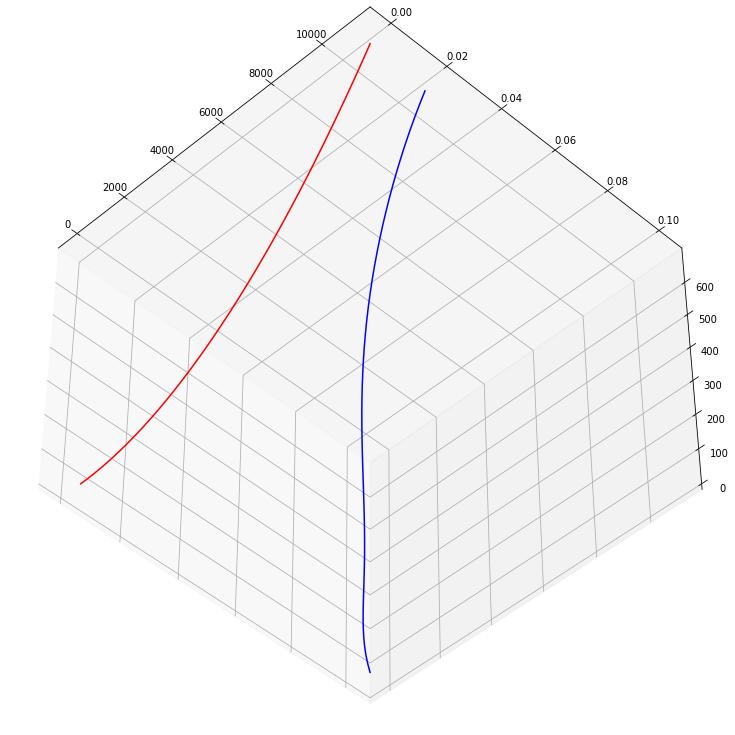

In [219]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [220]:
X,Y,Z

(array([2.00061951e-03, 2.25515330e+02, 4.50845038e+02, 6.76072816e+02,
        9.01236872e+02, 1.12634647e+03, 1.35140712e+03, 1.57642288e+03,
        1.80139687e+03, 2.02633160e+03, 2.25122912e+03, 2.47609117e+03,
        2.70091923e+03, 2.92571459e+03, 3.15047837e+03, 3.37521158e+03,
        3.59991509e+03, 3.82458973e+03, 4.04923620e+03, 4.27385516e+03,
        4.49844723e+03, 4.72301295e+03, 4.94755283e+03, 5.17206734e+03,
        5.39655693e+03, 5.62102199e+03, 5.84546290e+03, 6.06988003e+03,
        6.29427370e+03, 6.51864422e+03, 6.74299189e+03, 6.96731699e+03,
        7.19161977e+03, 7.41590049e+03, 7.64015937e+03, 7.86439664e+03,
        8.08861251e+03, 8.31280717e+03, 8.53698082e+03, 8.76113364e+03,
        8.98526580e+03, 9.20937747e+03, 9.43346879e+03, 9.65753992e+03,
        9.88159100e+03, 1.01056222e+04, 1.03296336e+04, 1.05536253e+04,
        1.07775974e+04, 1.10015501e+04]),
 array([0.10156545, 0.09859537, 0.09586251, 0.0933302 , 0.09096412,
        0.08873226, 0.0866

In [221]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [222]:
us=fin.T

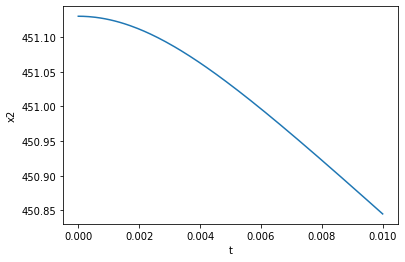

In [223]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

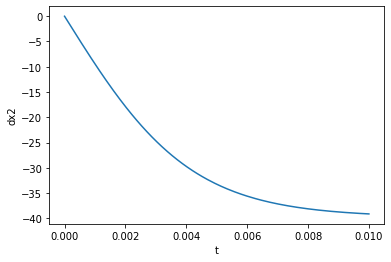

In [224]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

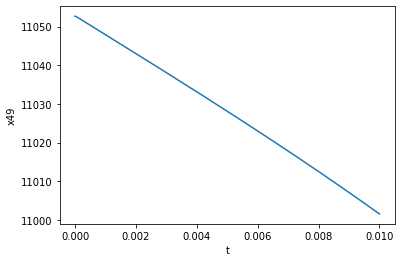

In [225]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

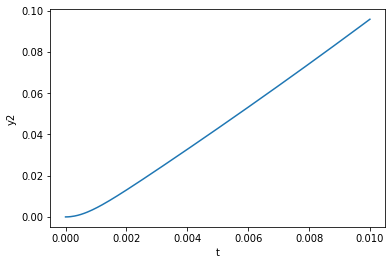

In [226]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

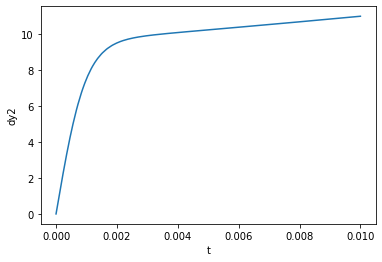

In [227]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

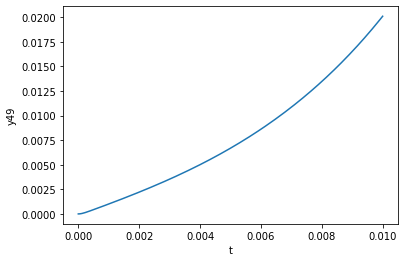

In [228]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

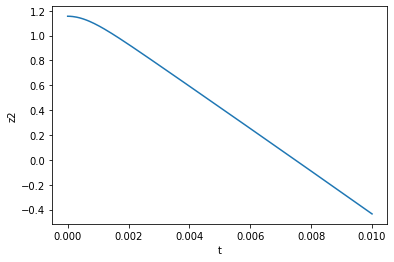

In [229]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

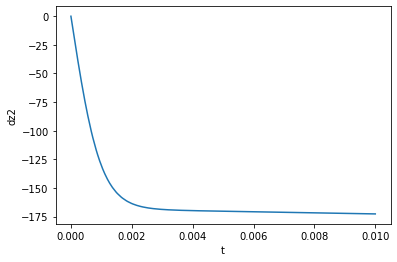

In [230]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

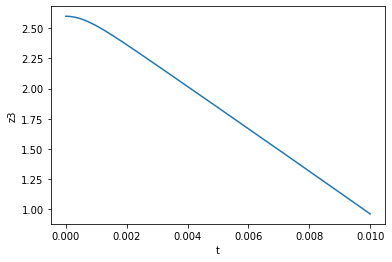

In [231]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

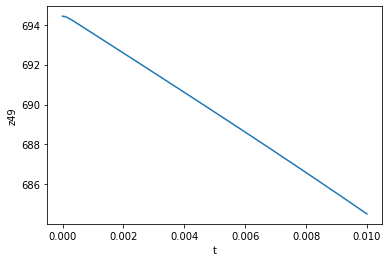

In [232]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

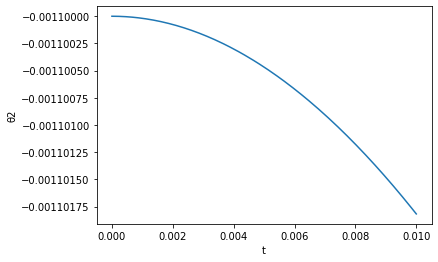

In [233]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

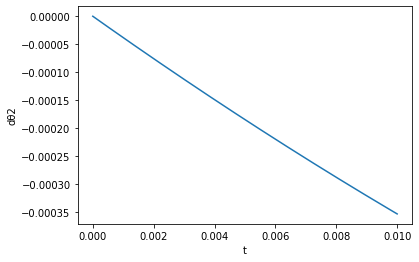

In [234]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

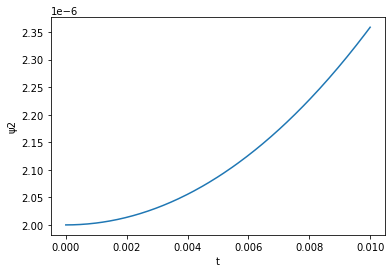

In [235]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

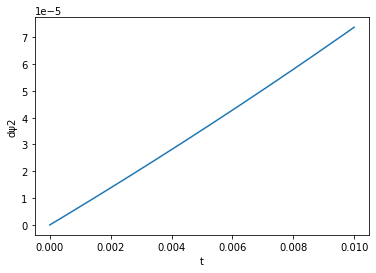

In [236]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()